In [1]:
from matplotlib import pyplot as plt
import audiofile
import numpy as np

# Using rVADfast instance

In [2]:
from rVADfast import rVADfast

In [3]:
from glob import glob
import re

def get_alignment(alignment_root, identifiers):
    speaker = str(identifiers[0])
    chapter = str(identifiers[1])
    utterance = str(identifiers[2])
    # Make sure utterance id is four digits
    utterance = f"{utterance:0>4}"

    alignment_identifier = '-'.join((speaker, chapter, utterance))

    path = alignment_root + speaker + "/" + chapter + "/"
    alignment_file = glob(path + "*alignment.txt")[0]
    with open(alignment_file, encoding="utf8") as file:
        timestamps = None
        for line in file.readlines():
            if alignment_identifier in line:
                aligned_text = line.split(' ')[1][1:-1]
                timestamps = line.split(' ')[2][1:-2]  # remove newline
                timestamps = timestamps.split(',')
                timestamps = np.array([float(timestamp) for timestamp in timestamps])
                labels = re.sub(r"[A-Z']+", 'W', aligned_text)  # we only need word or no word ("W", "")
                labels = np.char.array(labels.split(","), itemsize=4)
                break

        if timestamps is None:
            print(f"No alignment found for {alignment_identifier}")

    return timestamps, labels


def interpolate_labels(timestamps_interp, label_timestamps, labels):
    previous_index = 0
    labels_interp = np.zeros_like(timestamps_interp)
    for label, timestamp in zip(labels, label_timestamps):
        index = np.searchsorted(timestamps_interp, timestamp)
        labels_interp[previous_index:index] = label
        previous_index = index
    return labels_interp


In [4]:
from pathlib import Path

data_folder = "data/LibriSpeech_example/train-clean-100/"

signal, sampling_rate = audiofile.read(data_folder + "8629/261140/8629-261140-0001.flac")

identifiers = "8629-261140-0001".split("-")

timestamps, labels = get_alignment(alignment_root=data_folder, identifiers=identifiers)

labels = (labels=="W").astype(int)

signal_timestamps = np.arange(signal.shape[-1]) / sampling_rate

forced_alignment_labels = interpolate_labels(signal_timestamps, timestamps, labels)

vad = rVADfast()

rVAD_labels, rVAD_timestamps = vad(signal, sampling_rate)

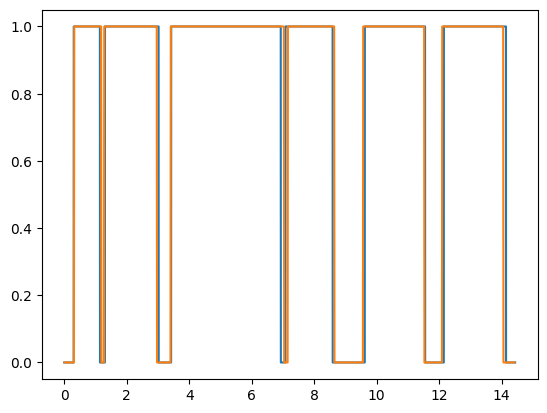

In [5]:
plt.plot(signal_timestamps, forced_alignment_labels)
plt.plot(rVAD_timestamps, rVAD_labels)

# rVADfast processing of multiple files
Finds audio files and generates .txt file with comma separated timestamps for start time and end time of speech segments.

In [6]:
from rVADfast.process import rVADfast_multi_process

## Generating vad labels
To generate vad labels the ```rVADfast.process``` module can be used which has the ```rVADfast_multi_process``` and ```rVADfast_multi_process```.

In [7]:
rVADfast_multi_process(root_folder=str(data_folder), save_folder=str(data_folder) + "/vad_labels/", extension = "flac", n_workers=4)

Scanning data/LibriSpeech_example/train-clean-100/ for files with extension='flac'...
Found 102 files.
Starting VAD using multiprocessing pool with n_workers=4.


Generating VAD labels: 100%|██████████| 102/102 [00:08<00:00, 12.60files/s]


## Generating speech-only files
If the vad labels themselves are not of interest, and you simply wish to trim non-speech segments from your audio files, you can pass the ```trim_non_speech``` keyword.
Doing so tells the function to trim the original signal from non-speech segments and save into ```save_folder```, instead of saving the vad timestamps.
The function keeps the original file_format of the input file.

In [8]:
rVADfast_multi_process(root_folder=str(data_folder), save_folder=str(data_folder) + "/speech_only/", extension = "flac", n_workers=4, trim_non_speech=True)

Scanning data/LibriSpeech_example/train-clean-100/ for files with extension='flac'...
Found 102 files.
Starting VAD using multiprocessing pool with n_workers=4.


Trimming non-speech segments: 100%|██████████| 102/102 [00:07<00:00, 13.21files/s]
